In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from models.price_history_seq2seq_native import PriceHistorySeq2SeqNative

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
num_epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 47

#trunc_backprop_len = ??

### Step 1 - collect data (and/or generate them)

In [5]:
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [6]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_path, batch_size=batch_size, with_EOS=False)
dp.inputs.shape, dp.targets.shape

((11374, 60, 1), (11374, 30))

In [7]:
aa, bb = dp.next()
aa.shape, bb.shape

((47, 60, 1), (47, 30))

### Step 2 - Build model

In [8]:
model = PriceHistorySeq2SeqNative(rng=random_state, dtype=dtype, config=config, with_EOS=False)

In [9]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)

learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/basic_rnn_cell_59/Tanh:0", shape=(47, 400), dtype=float32)

BasicDecoderOutput(rnn_output=<tf.Tensor 'decoder_rnn_layer/decoder/transpose:0' shape=(47, ?, 400) dtype=float32>, sample_id=<tf.Tensor 'decoder_rnn_layer/decoder/transpose_1:0' shape=(47, ?) dtype=int32>)

Tensor("decoder_rnn_layer/decoder/transpose:0", shape=(47, ?, 400), dtype=float32)

Tensor("readout_layer/readouts:0", shape=(?, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(47, 30), dtype=float32)

Tensor("error/Select:0", shape=(47, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [10]:
#show_graph(graph)

#### Conclusion
There is no way this graph makes much sense but let's give it a try to see how bad really is

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

## Basic RNN cell (without EOS)

In [11]:
model = PriceHistorySeq2SeqNative(rng=random_state, dtype=dtype, config=config, with_EOS=False)

In [12]:
rnn_cell = PriceHistorySeq2SeqNative.RNN_CELLS.BASIC_RNN
num_epochs = 20
num_epochs, num_units, batch_size

(20, 400, 47)

In [13]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [14]:
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='008_rnn_seq2seq_native_noEOS_60to30_20epochs')

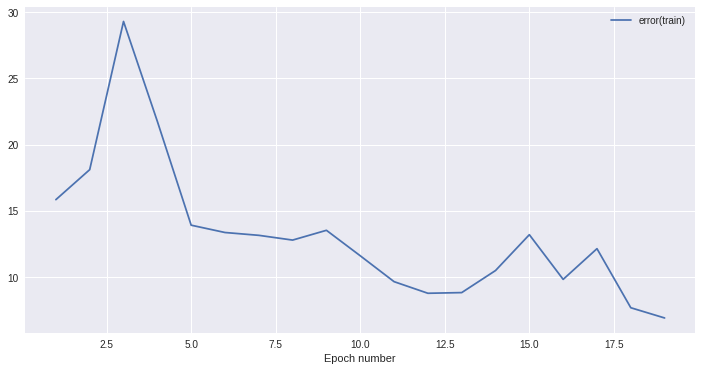

In [15]:
dyn_stats.plotStats()
plt.show()

In [16]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [17]:
ind = np.argmin(r2_scores)
ind

2685

In [18]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [19]:
r2_score(y_true=reals, y_pred=preds)

-2.1143813325132466e+31

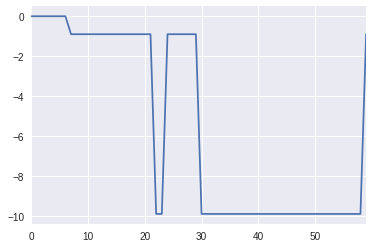

In [20]:
sns.tsplot(data=dp.inputs[ind].flatten())

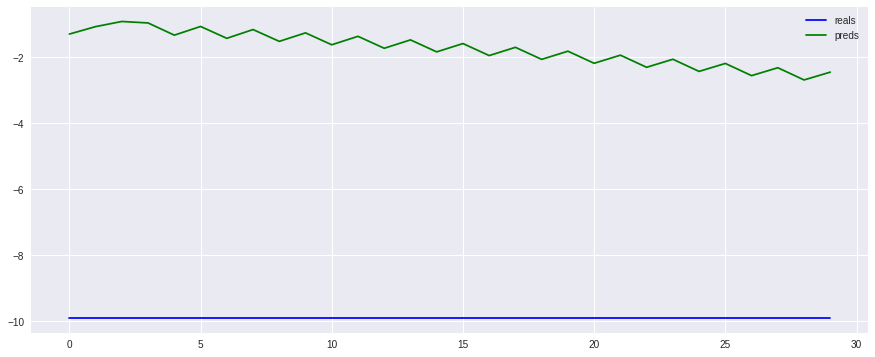

In [21]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [22]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.3 s, sys: 192 ms, total: 23.5 s
Wall time: 23.2 s


In [23]:
np.mean(dtw_scores)

188.88406655290186

In [24]:
coint(preds, reals)

(-2.6497142849470592,
 0.21818314084230767,
 array([-4.31395736, -3.55493606, -3.19393252]))

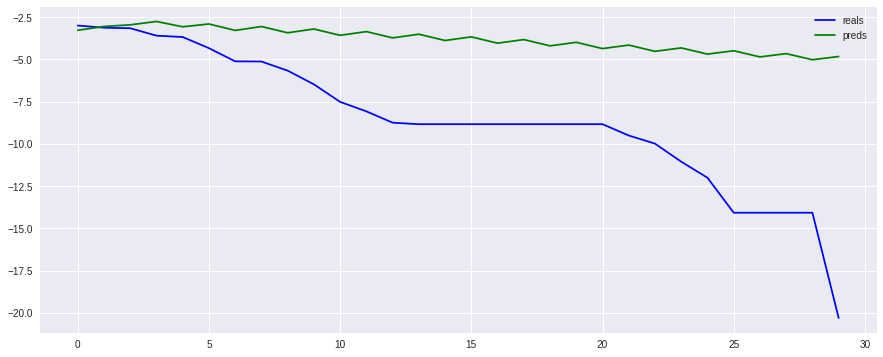

In [25]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
The initial price difference of the predictions is still not as good as we would expect, perhaps using an EOS as they do in machine translation models is not the best architecture for our case

## GRU cell - without EOS

In [26]:
rnn_cell = PriceHistorySeq2SeqNative.RNN_CELLS.GRU
num_epochs = 50
num_epochs, num_units, batch_size

(50, 400, 47)

In [27]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [28]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='008_gru_seq2seq_native_noEOS_60to30_50epochs')

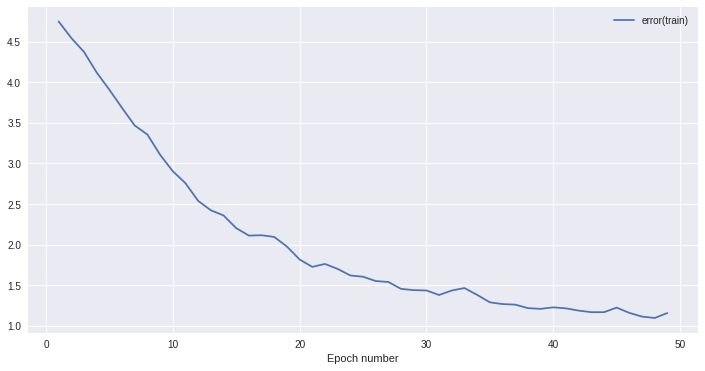

In [29]:
dyn_stats.plotStats()
plt.show()

In [30]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [31]:
ind = np.argmin(r2_scores)
ind

3918

In [32]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [33]:
r2_score(y_true=reals, y_pred=preds)

-1.2167426925305477e+30

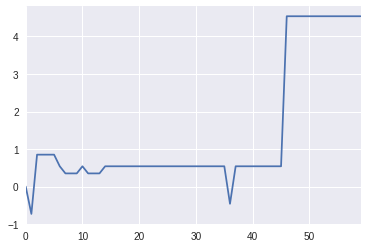

In [34]:
sns.tsplot(data=dp.inputs[ind].flatten())

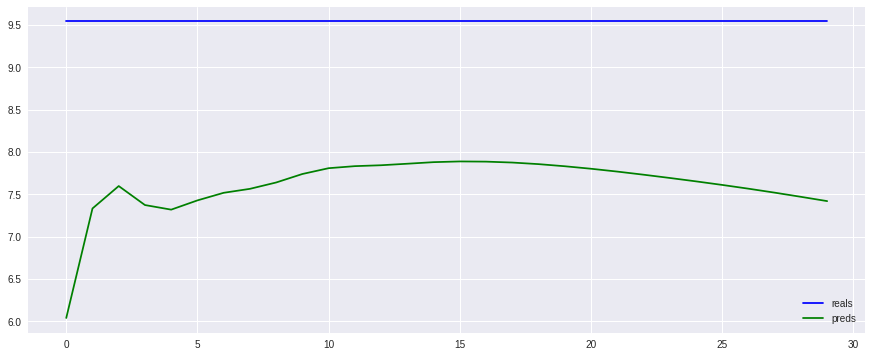

In [35]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [36]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.3 s, sys: 132 ms, total: 23.4 s
Wall time: 23.2 s


In [37]:
np.mean(dtw_scores)

35.344139465901698

In [38]:
coint(preds, reals)

(0.97963428756453885, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

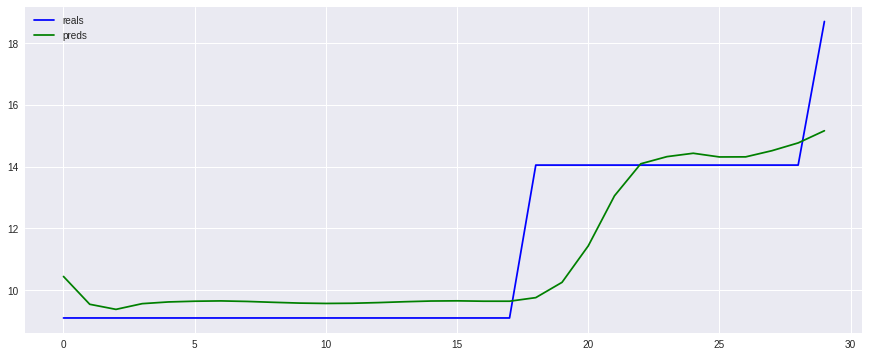

In [39]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???

## GRU cell - without EOS - 800 units

In [44]:
rnn_cell = PriceHistorySeq2SeqNative.RNN_CELLS.GRU
num_epochs = 30
num_units = 800
num_epochs, num_units, batch_size

(30, 800, 47)

In [45]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [46]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='008_gru_seq2seq_native_noEOS_60to30_30epochs_800units')

epochs: 30
End Epoch 01 (150.390 secs): err(train) = 5.6138
End Epoch 02 (149.876 secs): err(train) = 4.8436
End Epoch 03 (149.899 secs): err(train) = 4.6131
End Epoch 04 (149.849 secs): err(train) = 4.4298
End Epoch 05 (149.810 secs): err(train) = 4.2379
End Epoch 06 (149.858 secs): err(train) = 4.0636
End Epoch 07 (149.872 secs): err(train) = 3.8733
End Epoch 08 (149.823 secs): err(train) = 3.5976
End Epoch 09 (149.863 secs): err(train) = 3.3914
End Epoch 10 (149.828 secs): err(train) = 3.3177
End Epoch 11 (149.850 secs): err(train) = 3.0548
End Epoch 12 (149.851 secs): err(train) = 2.8281
End Epoch 13 (149.855 secs): err(train) = 2.7677
End Epoch 14 (149.833 secs): err(train) = 2.6391
End Epoch 15 (149.861 secs): err(train) = 2.4446
End Epoch 16 (149.834 secs): err(train) = 2.2878
End Epoch 17 (149.806 secs): err(train) = 2.1438
End Epoch 18 (149.735 secs): err(train) = 2.0683
End Epoch 19 (149.828 secs): err(train) = 1.9829
End Epoch 20 (149.783 secs): err(train) = 2.0159
End Epoch

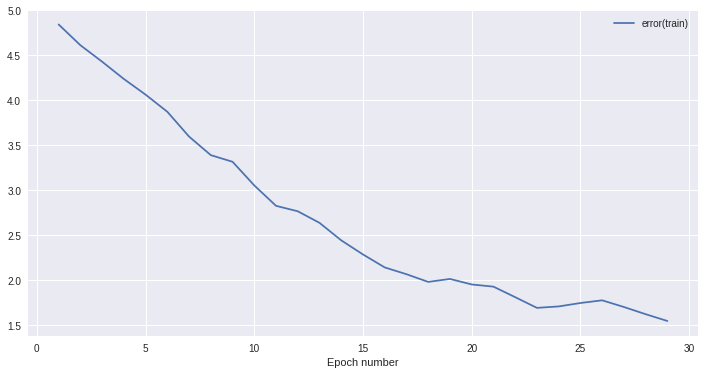

In [47]:
dyn_stats.plotStats()
plt.show()

In [48]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [49]:
ind = np.argmin(r2_scores)
ind

3918

In [50]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [51]:
r2_score(y_true=reals, y_pred=preds)

-5.3944625466477368e+29

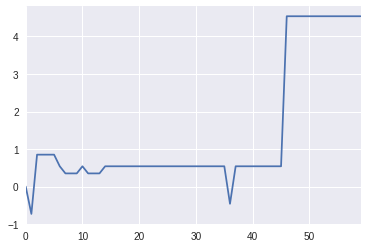

In [52]:
sns.tsplot(data=dp.inputs[ind].flatten())

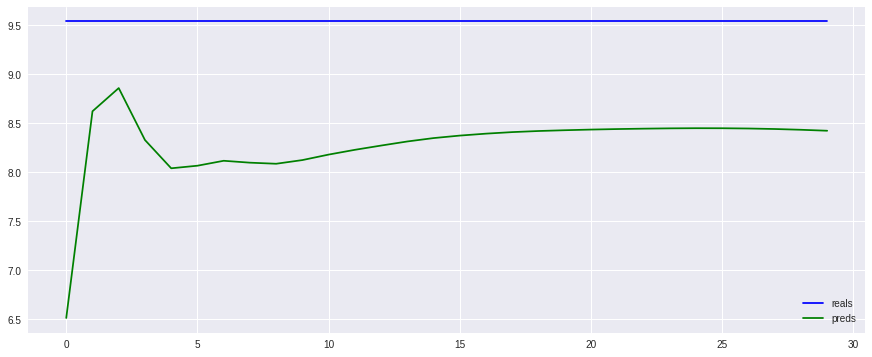

In [53]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [54]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.4 s, sys: 144 ms, total: 23.5 s
Wall time: 23.3 s


In [55]:
np.mean(dtw_scores)

45.158025378664014

In [56]:
coint(preds, reals)

(-6.3823275923841072,
 2.3264953250729143e-07,
 array([-4.31395736, -3.55493606, -3.19393252]))

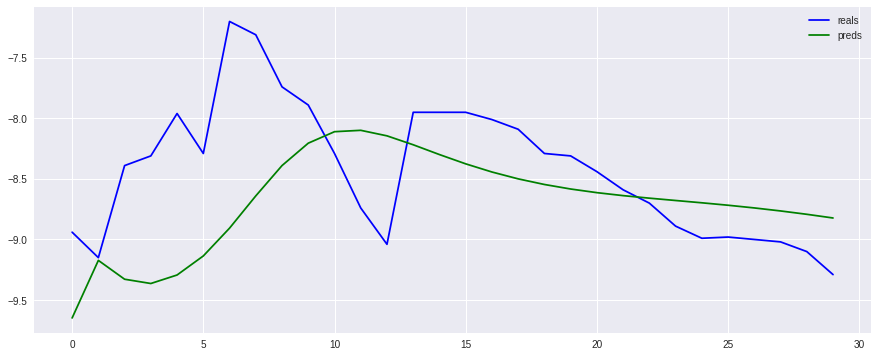

In [77]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???